<a href="https://colab.research.google.com/github/mabonmn/Quick_publish/blob/main/jeshmitha_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ortools

     |████████████████████████████████| 15.5 MB 314 kB/s 
     |████████████████████████████████| 1.0 MB 7.7 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import math
import numpy as np
!pip3 install pickle5
import pickle5 as pickle
from ortools.algorithms import pywrapknapsack_solver

import os
excel_path=('/content/drive/MyDrive/Feature Extraction - Mabon/coop/frame_score-P4/Knapsack_visualisation-1/TvSum.xlsx')
tvsum_h5_eccv= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/coop/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_eccv.h5', 'r')
v=15

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ECCV FILE
file_load= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/coop/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_eccv.h5', 'r')
gt_score=file_load['video_'+str(v)]['gtscore'][:]
gt_summary=file_load['video_'+str(v)]['gtsummary'][:]
n_frame=file_load['video_'+str(v)]['n_frames'][()]
picks=file_load['video_'+str(v)]['picks'][:]
change_pts=file_load['video_'+str(v)]['change_points'][:]
nfps=file_load['video_'+str(v)]['n_frame_per_seg'][:]
tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')

In [ ]:
#This function is to ensure that  the values are passed to the function in the appropriate data-type. 
#It also ensure that the inputed values are in the correct range.

def check_inputs(values,weights,n_items,capacity):
    # check variable type
    assert(isinstance(values,list))
    assert(isinstance(weights,list))
    assert(isinstance(n_items,int))
    assert(isinstance(capacity,int))
    # check value type
    assert(all(isinstance(val,int) or isinstance(val,float) for val in values))
    assert(all(isinstance(val,int) for val in weights))
    # check validity of value
    assert(all(val >= 0 for val in weights))
    assert(n_items > 0)
    assert(capacity > 0)

In [ ]:

osolver = pywrapknapsack_solver.KnapsackSolver(
    # pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
    pywrapknapsack_solver.KnapsackSolver.KNAPSACK_DYNAMIC_PROGRAMMING_SOLVER,
    'test')


In [ ]:
def knapsack_ortools(values, weights, items, capacity ):
    scale = 1000
    values = np.array(values)
    weights = np.array(weights)
    values = (values * scale).astype(np.int)
    weights = (weights).astype(np.int)
    capacity = capacity

    osolver.Init(values.tolist(), [weights.tolist()], [capacity])
    computed_value = osolver.Solve()
    packed_items = [x for x in range(0, len(weights))
                    if osolver.BestSolutionContains(x)]

    return packed_items



In [ ]:

#===========================================
'''
------------------------------------------------
Use dynamic programming (DP) to solve 0/1 knapsack problem
Time complexity: O(nW), where n is number of items and W is capacity

Author: Kaiyang Zhou
Website: https://kaiyangzhou.github.io/
------------------------------------------------
knapsack_dp(values,weights,n_items,capacity,return_all=False)

Input arguments:
  1. values: a list of numbers in either int or float, specifying the values of items
  2. weights: a list of int numbers specifying weights of items
  3. n_items: an int number indicating number of items
  4. capacity: an int number indicating the knapsack capacity
  5. return_all: whether return all info, defaulty is False (optional)

Return:
  1. picks: a list of numbers storing the positions of selected items
  2. max_val: maximum value (optional)
------------------------------------------------
'''
def knapsack_dp(values,weights,n_items,capacity,return_all=False):
    check_inputs(values,weights,n_items,capacity)

    table = np.zeros((n_items+1,capacity+1),dtype=np.float32)
    keep = np.zeros((n_items+1,capacity+1),dtype=np.float32)

    for i in range(1,n_items+1):
        for w in range(0,capacity+1):
            wi = weights[i-1] # weight of current item
            vi = values[i-1] # value of current item
            if (wi <= w) and (vi + table[i-1,w-wi] > table[i-1,w]):
                table[i,w] = vi + table[i-1,w-wi]
                keep[i,w] = 1
            else:
                table[i,w] = table[i-1,w]

    picks = []
    K = capacity

    for i in range(n_items,0,-1):
        if keep[i,K] == 1:
            picks.append(i)
            K -= weights[i-1]

    picks.sort()
    picks = [x-1 for x in picks] # change to 0-index

    if return_all:
        max_val = table[n_items,capacity]
        return picks,max_val
    return picks







In [ ]:
def generate_summary3(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.
    - cps: change points, 2D matrix, each row contains a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    if len(ypred)==n_frames:
      frame_scores=ypred
    elif len(ypred)==len(positions):
      for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(ypred):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = ypred[i]
    else:
      print("check the length of frame scores")

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        #picks = knapsack_dp(seg_score, nfps, n_segs, limits)
        picks = knapsack_ortools(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))

    summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    frame_seg_score=[]
    for seg_idx in range(n_segs):
        nf = nfps[seg_idx]
        frame_seg_score.extend([seg_score[seg_idx] for i in range(nf)])
        if seg_idx in picks:
            tmp = np.ones((nf), dtype=np.float32)
        else:
            tmp = np.zeros((nf), dtype=np.float32)
        summary = np.concatenate((summary, tmp))

    summary = np.delete(summary, 0) # delete the first element

    return frame_seg_score, summary


In [ ]:
def color_coding(summary):
  c=[]
  for x in summary:
    if x==0:
      c.append('red')
    elif x==1:
      c.append('green')
  return c

In [ ]:
tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')

p=tvsum_h5_eccv['video_'+str(v)]['picks'][:]
nf=tvsum_h5_eccv['video_'+str(v)]['n_frames'][()]


cp_e=tvsum_h5_eccv['video_'+str(v)]['change_points'][:]

nfps_e=tvsum_h5_eccv['video_'+str(v)]['n_frame_per_seg'][:]


3.9

In [ ]:
gt_normalized=[]

In [ ]:

max=np.amax(gt)
min=np.amin(gt)
size=gt.shape
size=size[0]

for i in range(size):
  temp=(gt[i]-min)/(max-min)
  gt_normalized.append(temp)
gt_normalized=np.array(gt_normalized)

In [ ]:


frame_seg_score_e, summary_e=generate_summary3(gt_normalized, cp_e, nf, nfps_e, p)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

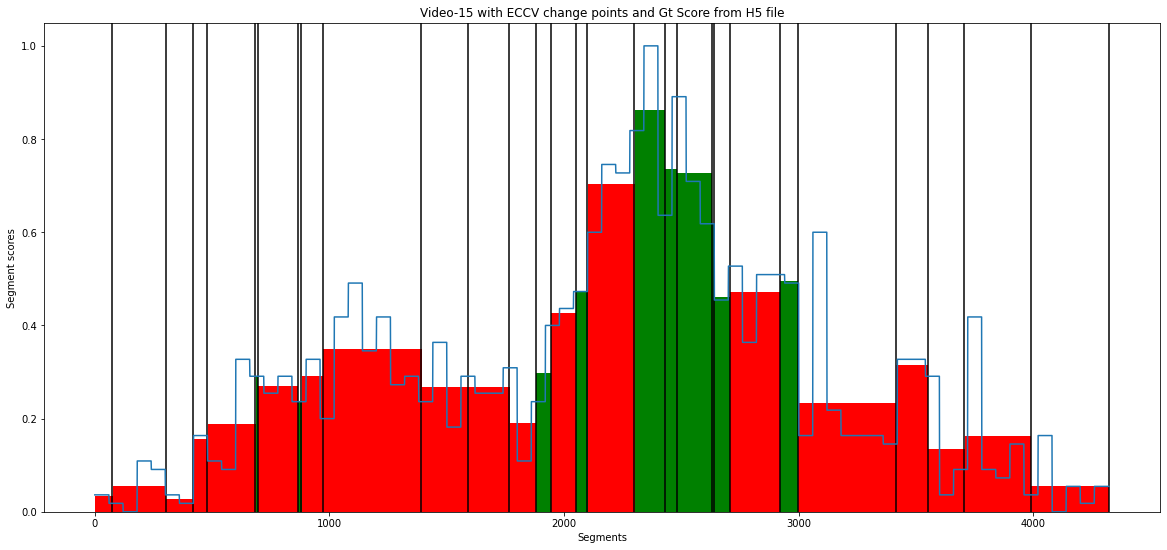

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_e, width=1, color=color_coding(summary_e))
for s in cp_e:
  plt.axvline(x=s[1], color='black')
plt.plot(list(range(0, nf)), gt_normalized)
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with ECCV change points and Gt Score from H5 file")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()

In [ ]:
a=[0.00345714,0.00344241,0.00342763,0.0034198,0.0034199,0.00342497,0.00343023,0.00343327,0.0034333,0.00343319,0.00343743,0.00344474,0.00345319,0.00345786,0.00345489,0.00344613,0.00343626,0.00343178,0.00343411,0.00344265,0.00345088,0.00345461,0.00345194,0.00344559,0.00344229,0.00344511,0.0034534,0.00346427,0.0034715,0.00347122,0.00346503,0.0034571,0.00344862,0.00344388,0.00344235,0.00344121,0.00344084,0.00344049,0.00344164,0.00344431,0.00344827,0.00345138,0.00345267,0.00345511,0.00345794,0.00346362,0.00347022,0.00347688,0.00347958,0.00347632,0.00346735,0.00345765,0.00345132,0.00345106,0.00345689,0.00346514,0.00347335,0.00347811,0.00347695,0.00347131,0.0034647,0.00345877,0.00345385,0.00345153,0.00345001,0.00345186,0.0034557,0.00345975,0.00346511,0.00346836,0.00347197,0.00347367,0.00347327,0.00347139,0.0034674,0.00346203,0.0034564,0.00345103,0.00344562,0.00344217,0.00344017,0.00344005,0.00344163,0.00344463,0.00345015,0.0034542,0.00345594,0.00345539,0.00345351,0.0034508,0.0034499,0.00345268,0.00345754,0.00346185,0.00346306,0.00345998,0.00345622,0.00345703,0.00346241,0.00347228,0.00348243,0.00348699,0.00348544,0.00347905,0.00346977,0.00346138,0.00345836,0.00345636,0.00345742,0.00345685,0.00345422,0.00345005,0.00344721,0.00344753,0.00345303,0.00345959,0.00346536,0.00346747,0.0034657,0.00346047,0.00345957,0.00346346,0.00347234,0.0034831,0.00349013,0.00349112,0.00348648,0.00347842,0.00347033,0.00346454,0.00346348,0.00346534,0.00346788,0.00346917,0.0034697,0.00346829,0.00346479,0.00346381,0.00346453,0.00346959,0.00347582,0.00348197,0.00348489,0.00348219,0.00347618,0.0034704,0.00346793,0.00347106,0.00347842,0.00348509,0.00348664,0.00348289,0.00347639,0.00347078,0.00346773,0.00346878,0.00346836,0.00346515,0.00346058,0.00345589,0.00345571,0.00346261,0.0034691,0.00347498,0.00347711,0.00347635,0.00347696,0.00348265,0.00349283,0.00350197,0.00350472,0.0035003,0.0034895,0.00348277,0.0034798,0.00348144,0.00348455,0.0034851,0.00347902,0.00347398,0.00347242,0.00347576,0.00348161,0.00348436,0.00348056,0.00347335,0.0034645,0.00346163,0.00346336,0.00346879,0.00347121,0.0034669,0.00345717,0.00344773,0.0034444,0.00344686,0.00345498,0.00346379,0.00346955,0.00346967,0.00346813,0.00346646,0.00346945,0.00347375,0.00347637,0.00347374,0.00346595,0.00345603,0.00344638,0.00343877,0.00343804,0.00344164,0.00344773,0.00345355,0.00345772,0.00345854,0.00345722,0.00345546,0.00345476,0.00345638,0.00346018,0.00346377,0.00346521,0.00346382,0.00345881,0.00345247,0.00344872,0.00344965,0.00345888,0.00346585,0.00347106,0.00347246,0.00346882,0.00346411,0.0034588,0.00345644,0.00345744,0.00345631,0.00345704,0.0034577,0.00345502,0.00345,0.00344567,0.00344373,0.00344526,0.00344881,0.00345183,0.00345418,0.00345459,0.00345224,0.00344957,0.0034477,0.00344736,0.00345038,0.00345505,0.00346008,0.00346515,0.00346792,0.00346812,0.00346516,0.00346167,0.00345683,0.00345149,0.00344643,0.00344236,0.00344052,0.00343823,0.00343982,0.00344316,0.00344683,0.00344887,0.0034497,0.00344782,0.00344385,0.00343989,0.00343821,0.00344144,0.00344937,0.00346038,0.00347121,0.00347637,0.00347431,0.00346484,0.00345357,0.00344551,0.00344546,0.00345265,0.00346365,0.00347382]

In [ ]:
nf

4324

In [ ]:
def up_sample(score, n_frames, positions):
    
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(score):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = score[i]
            
    return frame_scores
pred=up_sample(a,n_frame,picks)

In [ ]:

max=np.amax(pred)
min=np.amin(pred)
size=pred.shape
size=size[0]
pred_normalized=[]
for i in range(size):
  temp=(pred[i]-min)/(max-min)
  pred_normalized.append(temp)
pred_normalized=np.array(pred_normalized)

In [ ]:
frame_seg_score_e, summary_e=generate_summary3(pred_normalized, cp_e, nf, nfps_e, p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

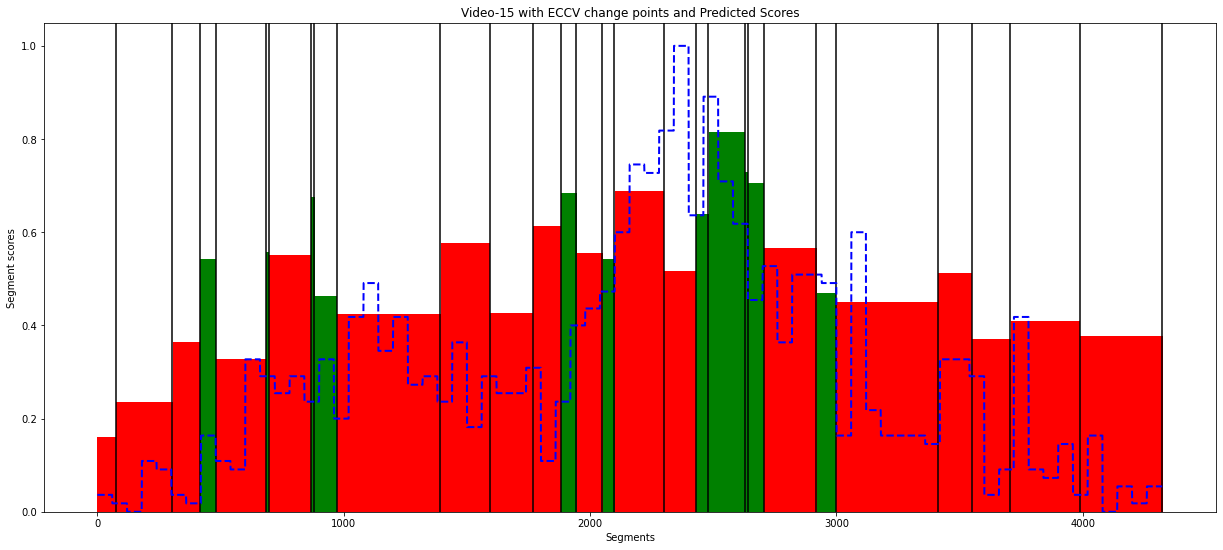

<Figure size 432x288 with 0 Axes>

In [ ]:

fig = plt.figure(figsize = (21, 9))
plt.bar(x=list(range(1, nf+1)), height=frame_seg_score_e, width=1, color=color_coding(summary_e))
for s in cp_e:
  plt.axvline(x=s[1], color='black')

plt.plot(list(range(0, nf)), gt_normalized,linewidth=2,linestyle = 'dashed',color='blue')
plt.xlabel("Segments")
plt.ylabel("Segment scores")
plt.title("Video-"+str(v)+" with ECCV change points and Predicted Scores")
plt.show()
#plt.savefig("ECCV/"+str(v)+".png")
plt.clf()

Text(0, 0.5, 'Scores')

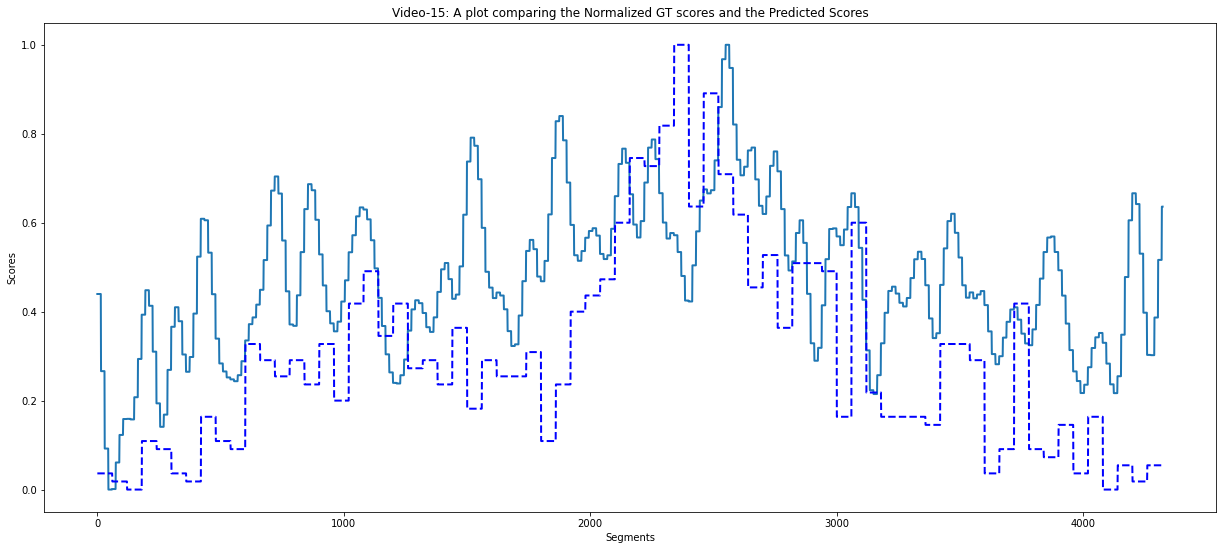

In [ ]:

fig = plt.figure(figsize = (21, 9))
plt.plot(list(range(0, nf)), pred_normalized,linewidth=2)
plt.title("Video-"+str(v)+": A plot comparing the Normalized GT scores and the Predicted Scores")
plt.plot(list(range(0, nf)), gt_normalized,linewidth=2,linestyle = 'dashed',color='blue')
plt.xlabel("Segments")
plt.ylabel("Scores")